In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!7z x "/content/drive/MyDrive/DSAI/data"

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!cp -r /content/origin /content/drive/MyDrive/DSAI/ExpW_Data

In [ ]:
# Define file paths for label information and image data
label_file_path = "/content/drive/MyDrive/DSAI/data/label/label.lst"
images_folder_path = "/content/drive/MyDrive/DSAI/ExpW_Data/origin"

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read the label information into a pandas DataFrame
df_info = pd.read_csv(label_file_path, sep=" ", header=None)
col_names = "image_name face_id_in_image face_box_top face_box_left face_box_right face_box_bottom face_box_cofidence expression_label".split()
df_info.columns = col_names

In [ ]:
# Filter the DataFrame to keep only the confident face detections
df_sel = df_info[df_info.face_box_cofidence > 30]

<ipython-input-8-c060370eb5aa>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='expression_label', data=df_info, palette=custom_colors)


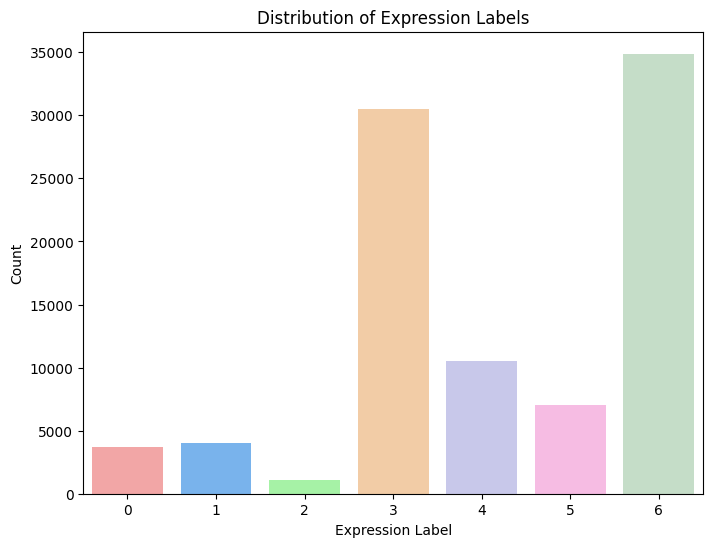

In [ ]:
# Plot a bar chart for expression labels to understand the label distribution

# Define custom colors for each bar
custom_colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#c1e1c5']

# Plot a bar chart with custom colors
plt.figure(figsize=(8, 6))
sns.countplot(x='expression_label', data=df_info, palette=custom_colors)

# Add labels and title
plt.xlabel('Expression Label')
plt.ylabel('Count')
plt.title('Distribution of Expression Labels')
plt.show()

In [ ]:
# Prepare the data for model training by cropping and resizing the images
x = []
y = []
for i, row in df_sel.sample(5000).iterrows():
    img_name = row["image_name"]
    x1 = row["face_box_left"]
    x2 = row["face_box_right"]
    y1 = row["face_box_top"]
    y2 = row["face_box_bottom"]
    label = row["expression_label"]
    img_path = os.path.join(images_folder_path, img_name)
    img = cv2.imread(img_path)
    # Check if img is not None
    if img is not None:
        # Crop the image using the provided coordinates
        cropped_img = img[y1:y2, x1:x2]
    else:
        continue

    if cropped_img is not None:
        # Resize the cropped image to a fixed size (e.g., 64x64)
        resized_face = cv2.resize(cropped_img, (64, 64))
    else:
        continue

    # Normalize the image data (scaling pixel values to the range [0, 1])
    normalized_face = resized_face / 255.0
    x.append(normalized_face)
    y.append(label)

In [ ]:
# Convert the lists to numpy arrays
X = np.array(x)
Y = np.array(y)

In [ ]:
# Split the data into training (70%), validation (15%), and testing (15%) sets
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Training set size: 2810
Validation set size: 602
Testing set size: 603


In [ ]:
# One-hot encode the target labels for training and validation sets
from keras.utils import to_categorical

Y_train_one_hot = to_categorical(Y_train, num_classes=7)
Y_val_one_hot = to_categorical(Y_val, num_classes=7)
Y_test_one_hot = to_categorical(Y_test, num_classes=7)

In [ ]:
# Import necessary libraries for building the model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
# Create the model architecture
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

# Compile the model
emotion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary for debugging
emotion_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,967,623 (18.95 MB)

 Trainable params: 4,967,623 (18.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Data augmentation using ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(X_train)


In [ ]:
# Create a TensorBoard callback to visualize training progress
from keras.callbacks import TensorBoard

log_dir = "/content/drive/MyDrive/project/logs"
tensorboard_callback = TensorBoard(log_dir=log_dir)

# Train the model using the augmented data and TensorBoard callback
history = emotion_model.fit(datagen.flow(X_train, Y_train_one_hot, batch_size=32),
                            epochs=30,
                            validation_data=(X_val, Y_val_one_hot),
                            callbacks=[tensorboard_callback])


Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.4281 - loss: 1.4655 - val_accuracy: 0.4452 - val_loss: 1.3805
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.4312 - loss: 1.4169 - val_accuracy: 0.4153 - val_loss: 1.3920
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 139s 1000ms/step - accuracy: 0.4603 - loss: 1.4084 - val_accuracy: 0.4452 - val_loss: 1.3853
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.4231 - loss: 1.4146 - val_accuracy: 0.4402 - val_loss: 1.3873
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 133s 991ms/step - accuracy: 0.4558 - loss: 1.4036 - val_accuracy: 0.4385 - val_loss: 1.3728
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4491 - loss: 1.4050 - val_accuracy: 0.4419 - val_loss: 1.3673
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4467 - loss: 1.3956 - val_accuracy: 0.4252 - val_loss: 1.3711
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.4391 - loss: 1.3996 - val_accuracy: 0.443

In [ ]:
# Import confusion matrix functionality
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# Make predictions on the test set
Y_pred_one_hot = emotion_model.predict(X_test)
Y_pred = np.argmax(Y_pred_one_hot, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step


In [ ]:
# Get the true labels for the test set
Y_test_true = np.argmax(Y_test_one_hot, axis=1)

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(Y_test_true, Y_pred)

In [ ]:
# Save the trained model to an HDF5 file
model_save_path = "/content/drive/MyDrive/project/emotion_model.h5"
emotion_model.save(model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/project/emotion_model.h5


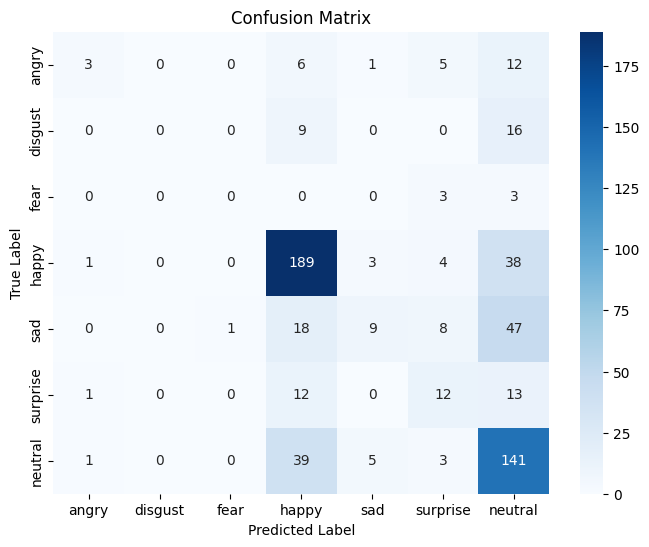

In [ ]:
# Display the confusion matrix using a heatmap
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [1]:
# import numpy as np
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Step 1: Make predictions
# Y_pred = emotion_model.predict(X_test)  # Replace X_test with your test data
# Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert predictions to class labels

# # Step 2: If Y_test is one-hot encoded, convert it back to class labels
# Y_true_classes = np.argmax(Y_test_one_hot, axis=1)  # Replace Y_test_one_hot with your true labels

# # Step 3: Calculate the confusion matrix
# cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# # Step 4: Plot the confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()
